In [1]:
import os
os.chdir("../../../")

In [2]:
import scanpy as sc
import surgeon
import numpy as np

Using TensorFlow backend.
/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mohammad/anaconda3/e

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["PBMC Kang - stimulated", "PBMC Kang - control"]

# Loading 6 PBMC datasets and data preparation

In [4]:
adata = sc.read("./data/pbmc_panorama/pbmc_panorama_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 58207 × 5131 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

## Number of cells in each batch & cell type

In [5]:
adata.obs[condition_key].value_counts()

PBMC 10X - control        26202
PBMC 68K - control        18006
PBMC Kang - stimulated     7451
PBMC Kang - control        6548
Name: study, dtype: int64

In [6]:
adata

AnnData object with n_obs × n_vars = 58207 × 5131 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

In [7]:
hvg = surgeon.utils.hvg_batch(adata, target_genes=500, batch_key=condition_key)

Using 69 HVGs from full intersect set
Using 60 HVGs from n_batch-1 set
Using 356 HVGs from n_batch-2 set
Using 15 HVGs from n_batch-3 set
Using 500 HVGs


In [8]:
adata = adata[:, hvg]
adata

View of AnnData object with n_obs × n_vars = 58207 × 500 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

In [9]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


/home/mohammad/anaconda3/envs/tf/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


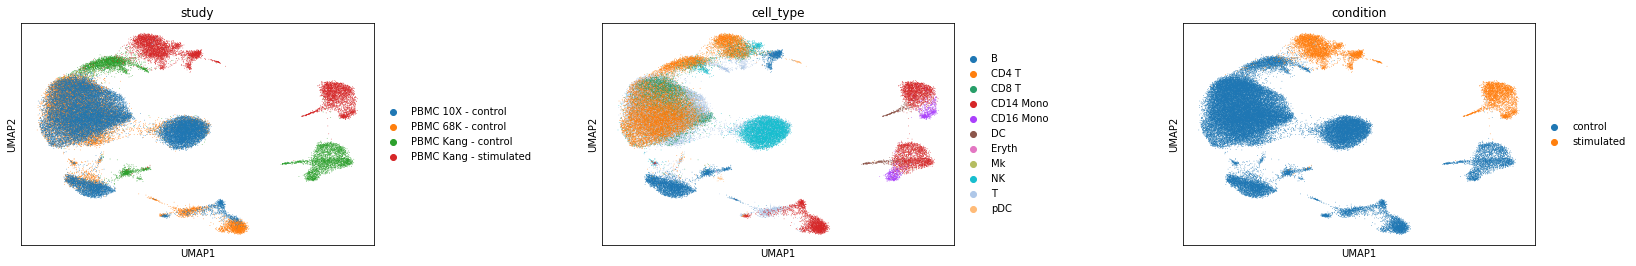

In [10]:
sc.pl.umap(adata, color=[condition_key, cell_type_key, "condition"], wspace=0.5)

## Now we leave out one study 

In [299]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 44208 × 500 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'
    uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_pca', 'X_umap'

In [300]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 13999 × 500 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'
    uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors', 'condition_colors'
    obsm: 'X_pca', 'X_umap'

## Train/Test Split

In [301]:
sc.pp.subsample(adata_for_training, fraction=0.2)

In [302]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.95)

In [303]:
train_adata.shape, valid_adata.shape

((8398, 500), (443, 500))

In [304]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [305]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128, 128, 128, 128, 128, 128, 10],
                             use_batchnorm=False,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.1,
                             beta=200.0,
                             eta=1,
                             clip_value=1000.0,
                             loss_fn='mse',
                             model_path="./models/CVAE/run/pbmc_panorama/before/",
                             dropout_rate=0.0005,
                             output_activation='relu')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 500)          0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 2)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          64256       data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_239 (LeakyReLU)     (None, 128)          0           first_layer[0][0]                
__________

## We assign each study to a numerical label 

In [306]:
conditions = adata.obs[condition_key].unique().tolist()

In [307]:
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)

## Training the network

In [308]:
network.train(train_adata,
              valid_adata,
              condition_key=condition_key,
              cell_type_key=cell_type_key,
              le=condition_encoder,
              n_epochs=300,
              batch_size=1024,
              early_stop_limit=50,
              lr_reducer=100,
              n_per_epoch=0,
              save=True,
              retrain=True,
              verbose=1)

Train on 8398 samples, validate on 443 samples
Epoch 1/300
8398/8398 [==============================] - 8s 1ms/step - loss: 29.2230 - reconstruction_loss: 21.4093 - mmd_loss: 7.8122 - val_loss: 28.6409 - val_reconstruction_loss: 21.5799 - val_mmd_loss: 7.0595
Epoch 2/300
8398/8398 [==============================] - 0s 14us/step - loss: 27.6267 - reconstruction_loss: 21.1702 - mmd_loss: 6.4550 - val_loss: 28.2558 - val_reconstruction_loss: 21.2304 - val_mmd_loss: 7.0239
Epoch 3/300
8398/8398 [==============================] - 0s 16us/step - loss: 25.2816 - reconstruction_loss: 20.7833 - mmd_loss: 4.4968 - val_loss: 24.3274 - val_reconstruction_loss: 20.6856 - val_mmd_loss: 3.6402
Epoch 4/300
8398/8398 [==============================] - 0s 14us/step - loss: 22.4586 - reconstruction_loss: 20.0319 - mmd_loss: 2.4251 - val_loss: 21.9431 - val_reconstruction_loss: 19.5251 - val_mmd_loss: 2.4165
Epoch 5/300
8398/8398 [==============================] - 0s 14us/step - loss: 20.1322 - reconstruc

In [309]:
network.condition_encoder

{'PBMC 68K - control': 0, 'PBMC 10X - control': 1}

In [310]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [311]:
latent_adata = network.to_mmd_layer(train_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8398 × 10 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

In [312]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

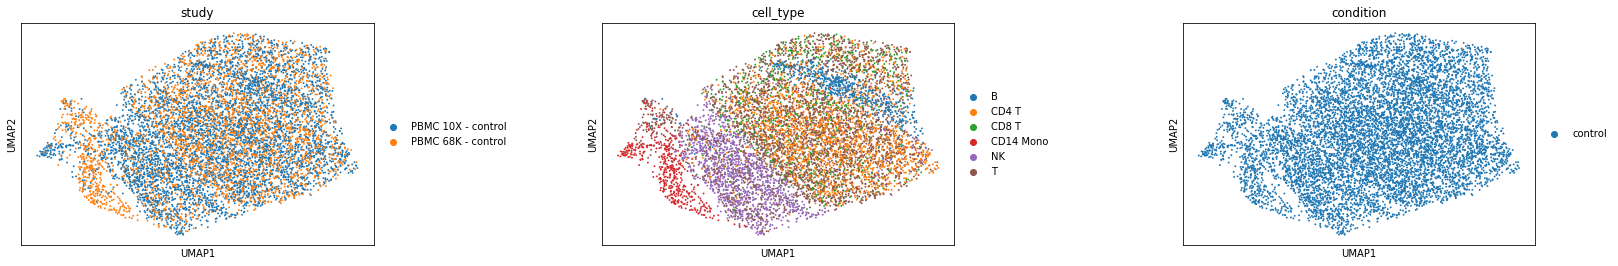

In [313]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key, "condition"], wspace=0.5)

In [314]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

0.602297249492011

In [315]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

0.5543337865458281

In [316]:
network.save_model()

In [317]:
network

# Perfroming architecture Surgery

In [318]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              remove_dropout=True,
                              init='zeros', 
                              freeze=True,
                              freeze_expression_input=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 500)          0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 4)            0                                            
__________________________________________________________________________________________________
first_layer (FirstLayer)        (None, 128)          64512       data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_253 (LeakyReLU)     (None, 128)          0           first_layer[0][0]                
__________

In [319]:
network.save_model()

In [320]:
new_network.condition_encoder

{'PBMC 68K - control': 0,
 'PBMC 10X - control': 1,
 'PBMC Kang - stimulated': 2,
 'PBMC Kang - control': 3}

## Train with small new dataset containing out-of-sample condition

In [321]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.9)

In [322]:
train_adata.shape, valid_adata.shape

((12599, 500), (1400, 500))

In [323]:
new_network.train(train_adata,
                  valid_adata,
                  condition_key=condition_key,
                  cell_type_key=cell_type_key,
                  le=new_network.condition_encoder,
                  n_epochs=100,
                  batch_size=512,
                  n_epochs_warmup=0,
                  early_stop_limit=100,
                  lr_reducer=100,
                  n_per_epoch=0,
                  save=False,
                  retrain=True,
                  verbose=1)

Train on 12599 samples, validate on 1400 samples
Epoch 1/100
12599/12599 [==============================] - 10s 788us/step - loss: 25.3472 - reconstruction_loss: 24.5972 - mmd_loss: 0.7484 - val_loss: 25.3256 - val_reconstruction_loss: 24.6445 - val_mmd_loss: 0.6795
Epoch 2/100
12599/12599 [==============================] - 0s 15us/step - loss: 25.2159 - reconstruction_loss: 24.5698 - mmd_loss: 0.6445 - val_loss: 25.3590 - val_reconstruction_loss: 24.6424 - val_mmd_loss: 0.7150
Epoch 3/100
12599/12599 [==============================] - 0s 16us/step - loss: 25.2009 - reconstruction_loss: 24.5523 - mmd_loss: 0.6470 - val_loss: 25.2723 - val_reconstruction_loss: 24.5999 - val_mmd_loss: 0.6708
Epoch 4/100
12599/12599 [==============================] - 0s 17us/step - loss: 25.1769 - reconstruction_loss: 24.5378 - mmd_loss: 0.6376 - val_loss: 25.2524 - val_reconstruction_loss: 24.5919 - val_mmd_loss: 0.6589
Epoch 5/100
12599/12599 [==============================] - 0s 15us/step - loss: 25.17

In [324]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [325]:
adata_out_of_sample.obs[condition_key].value_counts()

PBMC Kang - stimulated    7451
PBMC Kang - control       6548
Name: study, dtype: int64

In [326]:
latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 13999 × 10 
    obs: 'batch', 'cell_type', 'condition', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'seurat_annotations', 'stim', 'study', 'n_counts'

In [327]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

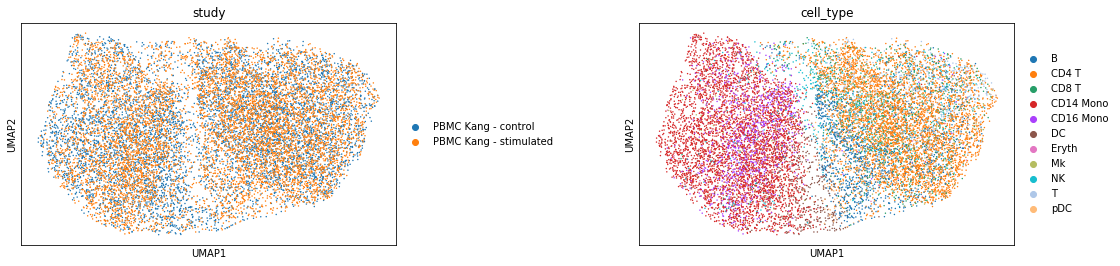

In [328]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [329]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

0.6242579348870302

In [330]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

0.3479934585536703

In [331]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

## MMD layer 

In [332]:
latent_adata = new_network.to_mmd_layer(adata, encoder_labels, encoder_labels)
latent_adata
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

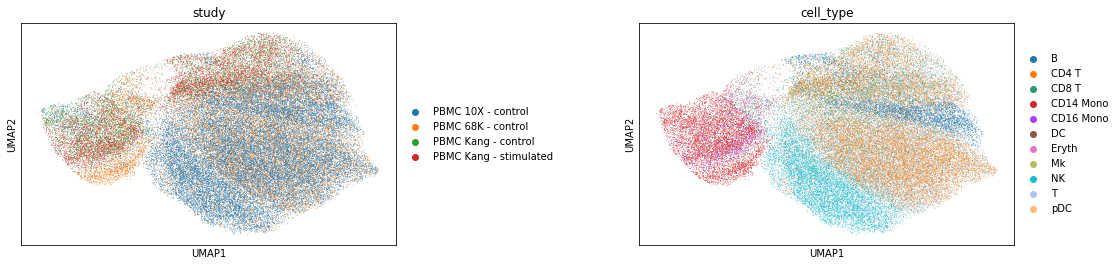

In [333]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [334]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

0.6953254403302117

In [335]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

0.3926782389849881

## Latent Layer

In [336]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

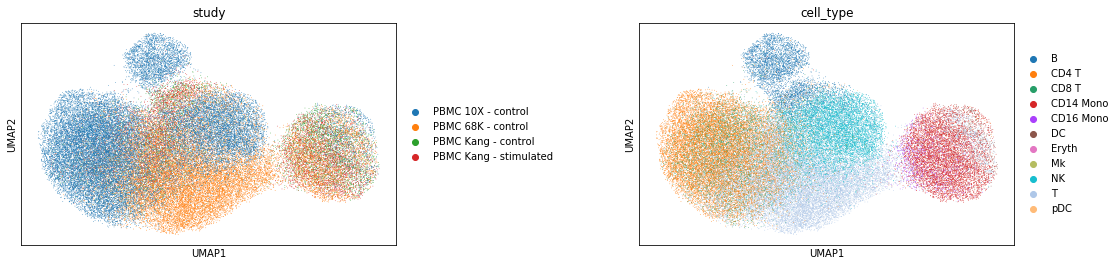

In [337]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)

In [338]:
surgeon.metrics.entropy_batch_mixing(latent_adata, n_neighbors=15, label_key=condition_key)

0.6089399844172034

In [339]:
surgeon.metrics.knn_purity(latent_adata, n_neighbors=15, label_key=cell_type_key)

0.42813746786813217